In [138]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools as itt
from ipywidgets import widgets
import ConfigReader as cr

In [139]:
#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [ ]:
# key -> dataset code, name -> dataset name
dataset_dict = {'1128_bac': 'OVA_Breast', '554_bac':'MNIST', '46_bac':'Splice'}

In [ ]:
[dataset_dict.get(k) for k in dataset_dict]

In [ ]:
reader = cr.ConfigReader()

In [ ]:
base_data_dir = '/mhome/mendozah/constrained_DeepNet_Configs/'
solvers = ['adam', 'adadelta', 'adagrad', 'nesterov', 'sgd', 'momentum']
solvers_dirs = list(map(lambda X: X + '_results', solvers))
policies = ['fixed', 'inv', 'exp', 'step']
interesting_params = [ 'response', 'solver', 'learning_rate', 'beta1', 'beta2', 'momentum',
                      'lambda2', 'lr_policy','gamma', 'power', 'epoch_step']

In [ ]:
[i for i in itt.product(solvers_dirs, policies)]

In [ ]:
[ x[1] for x in os.walk(os.path.join(base_data_dir, 'adam_results'))][1]

In [ ]:
mean_ds = []
sem_ds = []
params_frame = []
for key in dataset_dict:
    policy_solver_mean = []
    policy_solver_sem = []
    params_list = []
    for j in solvers_dirs:
        mean_list = []
        sem_list = []
        for i in policies:
            data_dir = os.path.join(base_data_dir, j, dataset_dict[key], i)
            _, bdf = reader.load_run_configs(data_dir=data_dir, dataset=key, preprocessor=None)
            params_list.append(bdf.ix[:, interesting_params])
            mean_list.append(bdf.response.mean())
            sem_list.append(bdf.response.sem())
        solver_mean = np.array(mean_list)
        solver_sem = np.array(sem_list)
        policy_solver_mean.append(solver_mean)
        policy_solver_sem.append(solver_sem)
    params_frame.append(pd.concat(params_list,axis=0))
    mean_df = pd.DataFrame(policy_solver_mean, index=solvers, columns=policies)
    sem_df = pd.DataFrame(policy_solver_sem, index=solvers, columns=policies)    
    mean_ds.append(mean_df)
    sem_ds.append(sem_df)
mean_datasets = pd.concat(mean_ds, axis=1, keys=[dataset_dict.get(k) for k in dataset_dict],
                          names = ['datasets', 'policies'])
sem_datasets = pd.concat(sem_ds, axis=1, keys=[dataset_dict.get(k) for k in dataset_dict],
                         names = ['datasets', 'policies'])
params_df = pd.concat(params_frame, axis=0, keys=[dataset_dict.get(k) for k in dataset_dict],
                      names=['dataset'])
params_df.loc[:, 'lr_policy'] = params_df.ix[:,'lr_policy'].fillna('fixed')
params_df = params_df.apply(pd.to_numeric, errors='ignore')

In [ ]:
params_df.loc[:, 'lr_policy'] = params_df.ix[:,'lr_policy'].fillna('fixed')
params_df = params_df.apply(pd.to_numeric, errors='ignore')
params_df = params_df.reset_index(level=0)

In [ ]:
mean_datasets.applymap(lambda X: "{:.3f}".format(X)) + '±' + sem_datasets.applymap(lambda x: "{:.3f}".format(x))

In [ ]:
grouped_df = mean_datasets.groupby(level=('policies'), axis=1)
mean_df = grouped_df.mean()
sem_df = sem_datasets.groupby(level=('policies'), axis=1).mean()

In [ ]:
mean_df.applymap(lambda X: "{:.4f}".format(X)) + ' ± ' + sem_df.applymap(lambda x: "{:.3f}".format(x))

In [ ]:
gmean = mean_datasets.groupby(level=('datasets'), axis=1)
gsem = sem_datasets.groupby(level=('datasets'), axis=1)
fig_means, axs = plt.subplots(nrows=1, ncols=3, figsize=(15., 7.), sharey=True)
for ax, (name, groups), (_, group_sem) in zip(axs.flat,gmean, gsem):
    groups.plot(kind='bar',label=name, alpha=0.9, ax=ax, yerr=group_sem)
    ax.set_title(name)
    ax.legend()
fig_means.suptitle('Mean Response 1-Hidden-Layer NN categorized on solver and learning rate policy over 3 datasets',
                   fontsize=14, y=1.02)
# fig_means.savefig(os.path.join('images', 'mean_response_datasets.png'))
plt.tight_layout()

In [ ]:
def bar_policy(policies):
    mean_df[policies].plot(kind='bar', yerr=sem_df[policies])

widgets.interact(bar_policy, policies=policies)

In [ ]:
mean_df.plot(kind='bar', yerr=sem_df)

In [ ]:
# Rescale values in log-scale
params_rescale = ['learning_rate','lambda2', 'beta1', 'beta2']
params_df.loc[:,params_rescale]=params_df.ix[:,params_rescale].applymap(lambda x: np.log10(x))

In [ ]:
# Plot the empirical CDF
sorted_Y = (params_df.sort_values(by='response', ascending=True)['response'].values)
yvals = np.arange(len(sorted_Y)) / float(len(sorted_Y))

plt.plot( sorted_Y, yvals )
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, 0.1)
plt.title("Empirical CDF of configurations based on validation error")
plt.show()

## After Setting the frames. Start with the plotting

In [ ]:
## TODO: Review how to make filtered and the figure return
def plotting_threshold(error_threshold, categories):
    #global filtered
    filtered = params_df[params_df.response <= error_threshold]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y='response', data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

In [ ]:
widgets.interact(plotting_threshold, error_threshold=(0.01,0.2,0.01),
                 categories={'Solver':'solver', 'Policy':'lr_policy'})

In [ ]:
# Create the grouping of the filtered DF
solver_filt = params_df.groupby('solver')

In [ ]:
g_barGrid = sns.FacetGrid(data=params_df, col='solver', row='lr_policy', hue='solver',
                              size=3.9, aspect=0.8)
g_barGrid.map(sns.distplot, 'learning_rate', hist=True, kde=False, rug=True, bins=6)
g_barGrid.add_legend()
g_barGrid.fig.suptitle('Distribution of learning rate',
                           fontsize=12, y=1.02)
g_barGrid.fig.subplots_adjust(wspace=.01,)
#g_barGrid.fig.savefig('images_'+  dataset_name + 'distro_lr_solver_vs_policy.png')

In [ ]:
g_kdeGrid = sns.FacetGrid(data=params_df, col='solver', hue='lr_policy',
                          col_wrap=3, size=3.9, aspect=0.8)
g_kdeGrid.map(sns.distplot, 'learning_rate', hist=False, kde=True, rug=True)
g_kdeGrid.add_legend()
g_kdeGrid.fig.suptitle('Distribution of learning rate',
                           fontsize=12, y=1.02)
g_kdeGrid.fig.subplots_adjust(wspace=.01,)
# g_kdeGrid.fig.savefig('images_'+ dataset_name + 'kde_lr_solver.png')

## Start with parameter importance plotting

In [3]:
import pyfanova.fanova

In [16]:
reload(pyfanova.fanova)

<module 'pyfanova.fanova' from '/home/mendozah/workspace/fanova/pyfanova/fanova.pyc'>

In [4]:
state_run_dir = "/mhome/mendozah/constrained_DeepNet_Configs/adam_results/MNIST/inv/merged_runs_inv/"

In [5]:
fano_MNIST = pyfanova.fanova.Fanova(state_run_dir)

In [10]:
marginals = fano_MNIST.print_all_marginals()

Sum of fractions for main effects 75.52%
Sum of fractions for pairwise interaction effects 22.86%
39.27% due to main effect: classifier:AdamInvConstFeedNet:lambda2
10.64% due to main effect: classifier:AdamInvConstFeedNet:beta1
9.37% due to main effect: classifier:AdamInvConstFeedNet:learning_rate
8.79% due to main effect: rescaling:__choice__
4.77% due to interaction: rescaling:__choice__ x classifier:AdamInvConstFeedNet:learning_rate
4.43% due to interaction: classifier:AdamInvConstFeedNet:lambda2 x classifier:AdamInvConstFeedNet:beta2
3.07% due to main effect: classifier:AdamInvConstFeedNet:beta2
2.65% due to interaction: classifier:AdamInvConstFeedNet:learning_rate x classifier:AdamInvConstFeedNet:lambda2
2.12% due to interaction: rescaling:__choice__ x classifier:AdamInvConstFeedNet:beta1
2.09% due to main effect: classifier:AdamInvConstFeedNet:gamma
2.08% due to main effect: classifier:AdamInvConstFeedNet:power
1.98% due to interaction: classifier:AdamInvConstFeedNet:lambda2 x cl

In [148]:
importance_params = [ 'learning_rate', 'beta1', 'beta2','lambda2','gamma', 'power']

In [2]:
import pyfanova.visualizer

In [143]:
reload(pyfanova.visualizer)

<module 'pyfanova.visualizer' from '/home/mendozah/workspace/fanova/pyfanova/visualizer.py'>

In [144]:
viz_MNIST = pyfanova.visualizer.Visualizer(fano_MNIST)

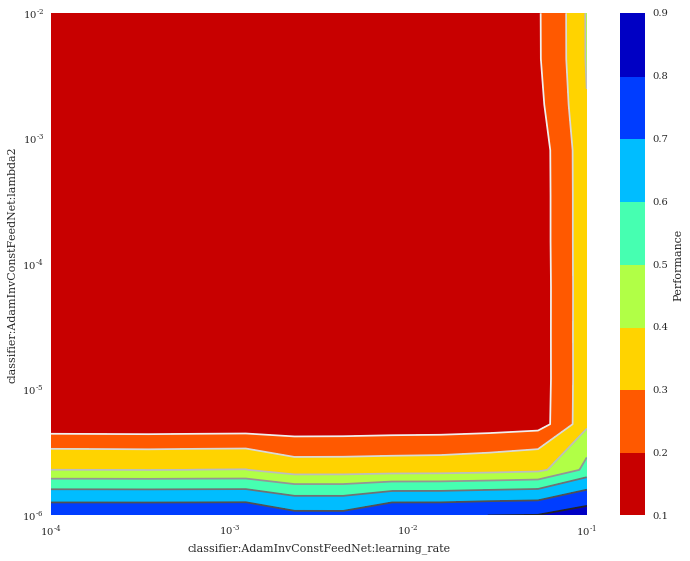

In [145]:
ax_params = viz_MNIST.plot_contour_pairwise('classifier:AdamInvConstFeedNet:learning_rate',
                                            'classifier:AdamInvConstFeedNet:lambda2',
                                            bounds_1=(0.0, 1.0), bounds_2=(0.0, 1.0),
                                            log_scale_1=True, log_scale_2=True,
                                            resolution=12)

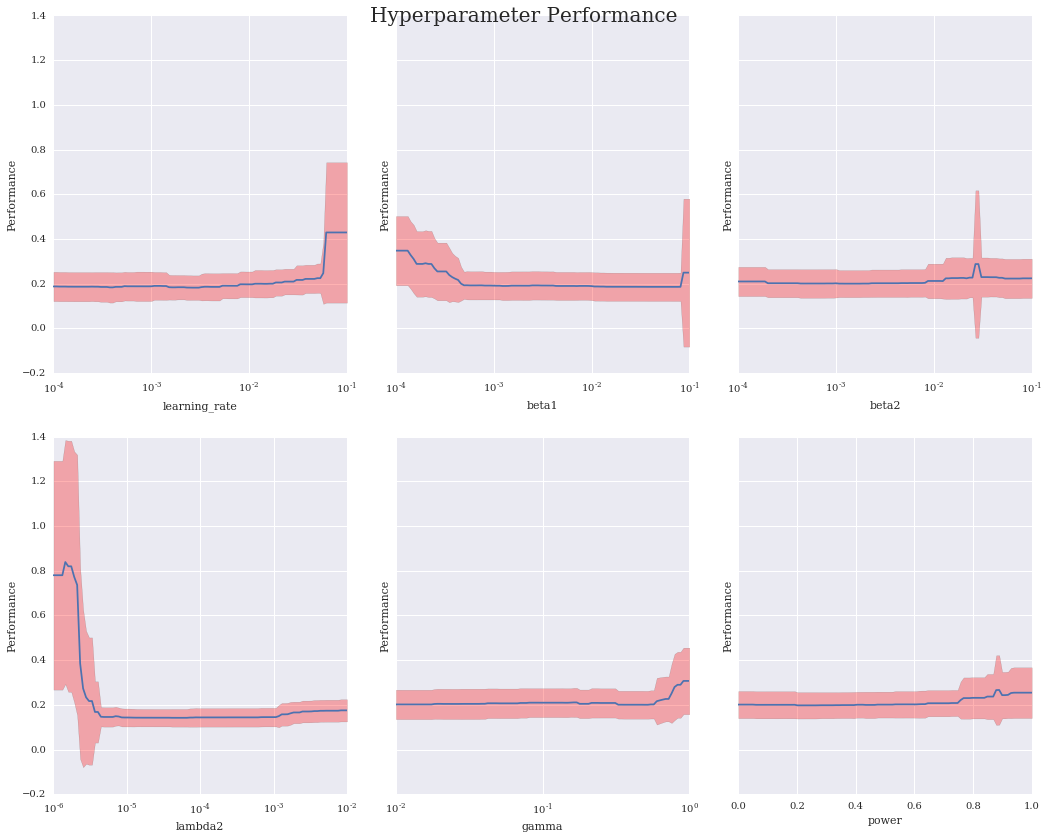

In [152]:
s = len(importance_params)
fig_effect, axp = plt.subplots(nrows=int(np.ceil(s/3.)), ncols=3, figsize=(15., 12.), sharey=True)
for ax, name in zip(axp.flat, importance_params):
    viz_MNIST.plot_marginal('classifier:AdamInvConstFeedNet:' + name, ax=ax)
    ax.set_xlabel(name)
fig_effect.suptitle('Hyperparameter Performance')
#fig_effect.savefig('images_'+ dataset_name +'joint_distro_lr_response.png')
plt.tight_layout()

In [ ]:
ax_params = viz_MNIST.plot_pairwise_marginal('classifier:AdamInvConstFeedNet:beta1',
                                             'classifier:AdamInvConstFeedNet:lambda2', resolution=50)

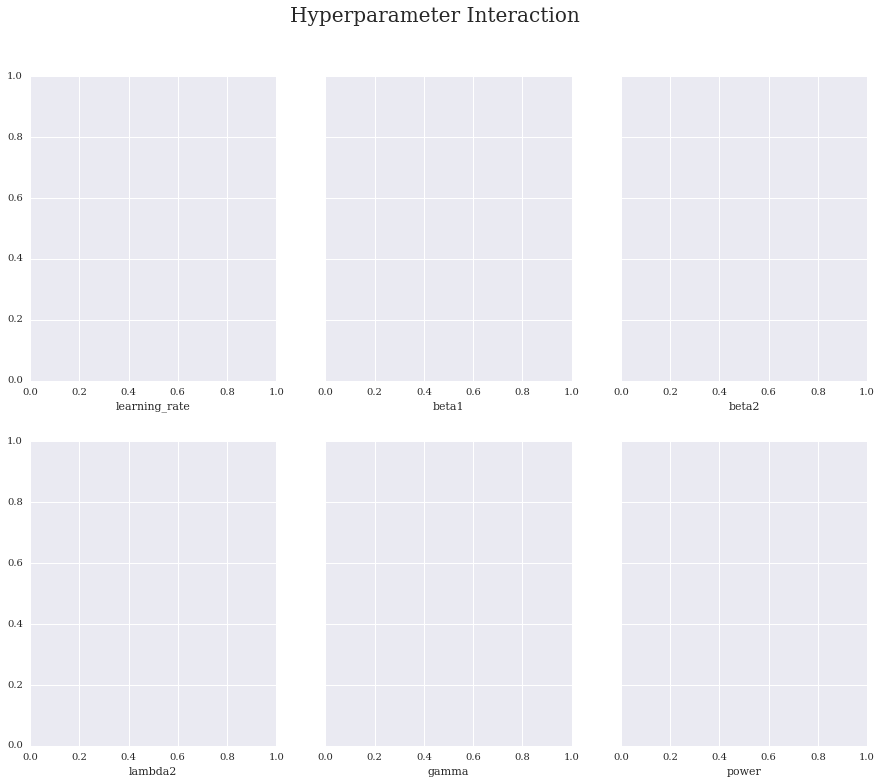

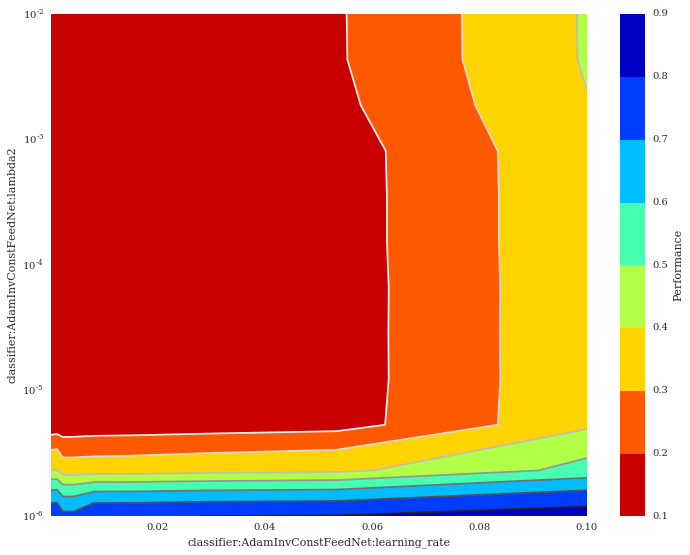

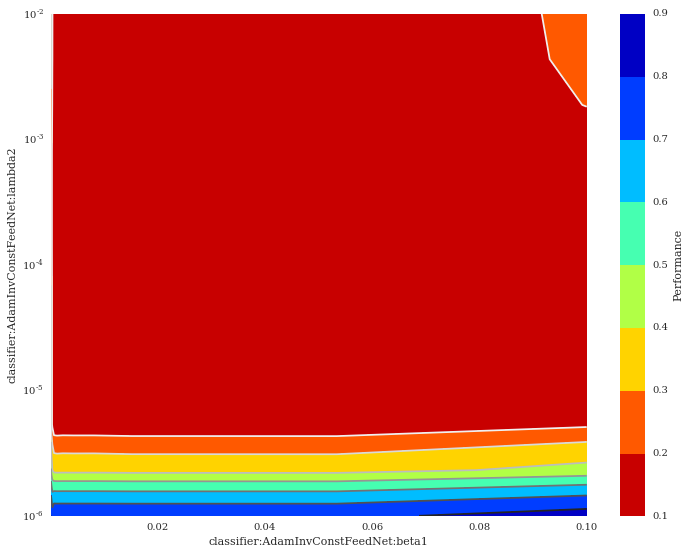

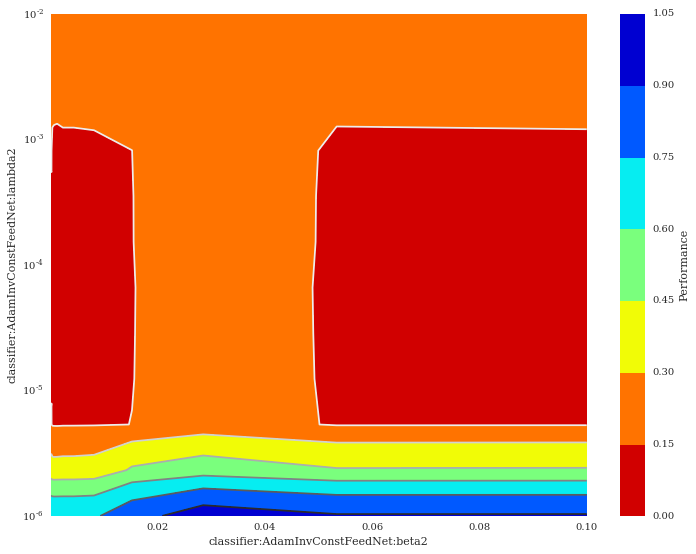

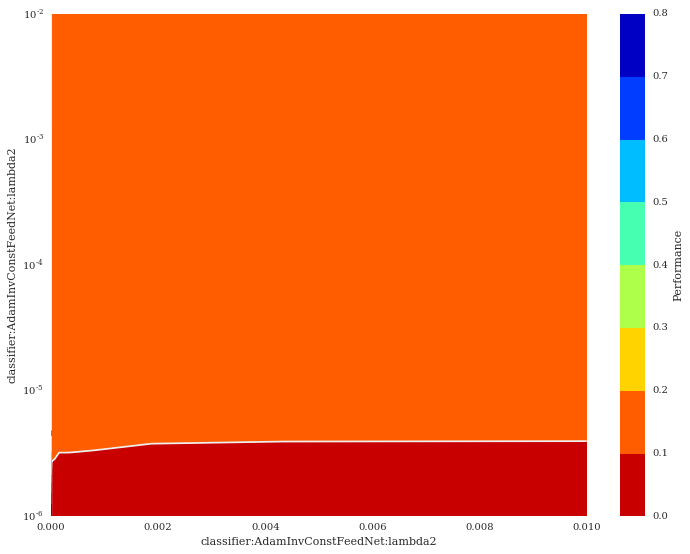

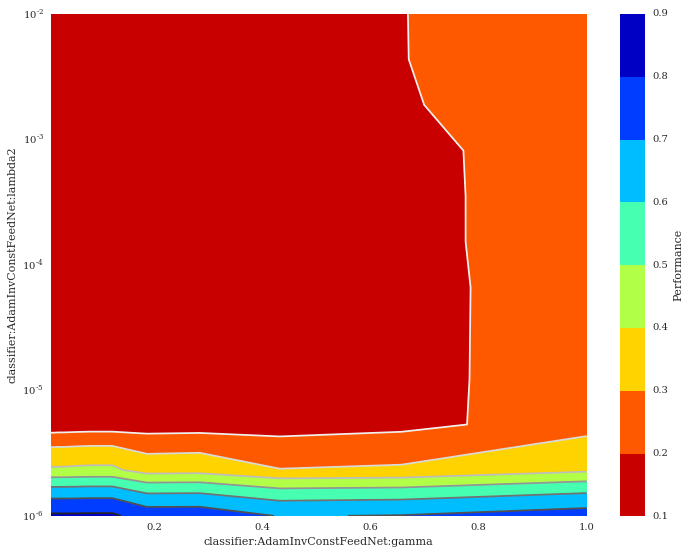

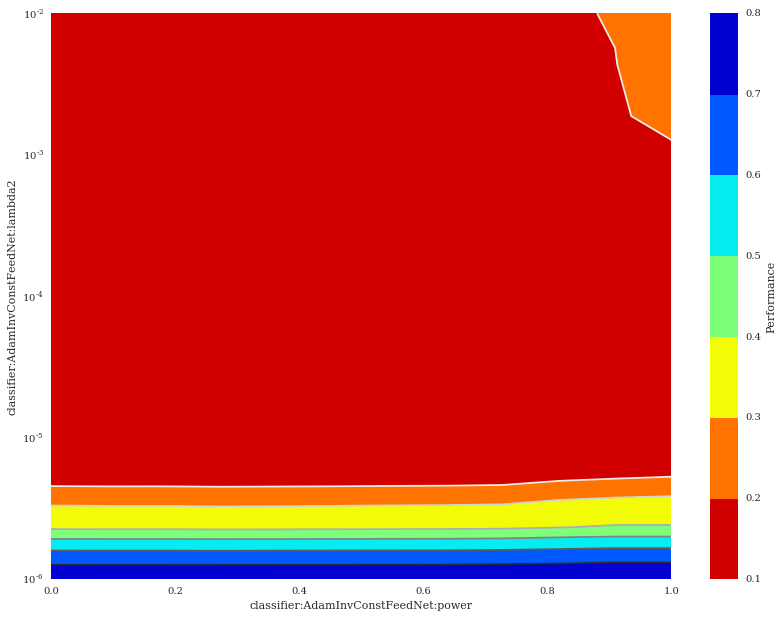

In [155]:
s = len(importance_params)
fig_interaction, axi = plt.subplots(nrows=int(np.ceil(s/3.)), ncols=3, figsize=(15., 12.), sharey=True)
for ax, name in zip(axi.flat, importance_params):
    viz_MNIST.plot_contour_pairwise('classifier:AdamInvConstFeedNet:' + name,
                                    'classifier:AdamInvConstFeedNet:lambda2',
                                    bounds_1=(0.0, 1.0), bounds_2=(0.0, 1.0),
                                    log_scale_1=False, log_scale_2=True,
                                    resolution=12)
    ax.set_xlabel(name)
fig_interaction.suptitle('Hyperparameter Interaction')
#fig_kde.savefig('images_'+ dataset_name +'joint_distro_lr_response.png')
plt.tight_layout()

In [ ]:
ax_params = viz_MNIST.plot_3dcontour('classifier:AdamInvConstFeedNet:learning_rate',
                                     'classifier:AdamInvConstFeedNet:lambda2',
                                     bounds_1=(0.0, 1.0), bounds_2=(0.0, 1.0),
                                     log_scale_1=False, log_scale_2=False,
                                     resolution=10)

### Density estimation and histograms of parameters based on filters

In [ ]:
# Seaborns Normed Distribution plots
for name,groups in solver_filt:
    sns.distplot(groups.learning_rate.values, bins=6, kde_kws={'label':name})

In [ ]:
#Subplots of the previous histogram
color_histograms = sns.color_palette('Set1_r',12, desat=1.0)
fig1, axs = plt.subplots(nrows=3, ncols=2, sharey='row', sharex=True)
for iterate_axis, (name, groups) in zip(axs.flat, solver_filt):
    sns.distplot(groups.learning_rate.values, bins=6, kde_kws={'label':name},
                 color=color_histograms.pop(), ax=iterate_axis)
    iterate_axis.legend()

In [ ]:
# Create the grouping of the filtered DF
prepro_filt = params_df.groupby('lr_policy')

In [ ]:
def histogram_group_column_plotting(grouping, column):
    #Have to convert the -1 to NaN
    g = params_df.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col', sharey='row', figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat,g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [ ]:
# Create columns dict
Groups = ['solver','lr_policy']
Plott = {'Learning Rate':'learning_rate', 'beta 1':'beta1', 'beta 2':'beta2',
         'Regularization Param':'lambda2', 'gamma':'gamma', 'power':'power', 'step size':'epoch_step'}

In [ ]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all configurations

In [ ]:
def histogram_column_plotting(column):
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    params_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

In [ ]:
widgets.interact(histogram_column_plotting, column=list(params_df.columns.values[1:]))